# Parallel Processing of Wine Review Data

### Load Wine Review Data

Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from IPython.display import Markdown, display
from tqdm import tqdm

Source: Kaggle [Wine Reviews](https://www.kaggle.com/datasets/zynicide/wine-reviews)

In [ ]:
wine_df = pd.read_parquet('data/wine/wine_review.parquet.gzip')
wine_df.info()
wine_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100538 entries, 0 to 129970
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   country                   100538 non-null  object 
 1   description               100538 non-null  object 
 2   points                    100538 non-null  int64  
 3   price                     93522 non-null   float64
 4   taster_name               100538 non-null  object 
 5   title                     100538 non-null  object 
 6   variety                   100538 non-null  object 
 7   winery                    100538 non-null  object 
 8   year                      100538 non-null  int64  
 9   wine_style                100538 non-null  object 
 10  type                      100538 non-null  object 
 11  quality                   100538 non-null  object 
 12  classification            100538 non-null  object 
 13  location                  100538 non-null  object

,country,description,points,price,taster_name,title,variety,winery,year,wine_style,type,quality,classification,location,band,preprocessed_description
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013,light_white,white,medium,Old World,Etna,None,aroma include tropical fruit broom brimstone...
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,medium_red,red,medium,Old World,Douro,popular,do ripe fruity wine smooth structure firm tann...
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,light_white,white,medium,New World,Oregon,popular,rainstorm tart snappy flavor lime flesh rind d...
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,aromatic_white,white,medium,New World,Michigan,popular,pineapple rind lemon pith orange blossom start...
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,light_red,red,medium,New World,Oregon,luxury,vintner like regular bottling come rough tanni...


**Stratified Sampling of Reviews by Variety**

The full dataset is quite large and NLP preprocessing, like Named Entity Recognition, can take some time to process. Let's create a subset of the data to test the performance of the NLP preprocessing we need to do and see if we need to worry about performance.

In [4]:
subset = wine_df.groupby('variety')[['description', 'variety']].apply(lambda row: row.sample(frac=0.01)).reset_index(drop=True).sample(frac=1)
subset.info()
subset.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1005 entries, 501 to 577
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  1005 non-null   object
 1   variety      1005 non-null   object
dtypes: object(2)
memory usage: 23.6+ KB


,description,variety
501,There's a toughness to this wine that makes it...,Pinot Noir
381,Lots of acidity gives this Merlot a bite. It's...,Merlot
283,"Marginally better than the regular Chardonnay,...",Chardonnay
29,"The wine is equally sharp, with a spicy blend ...",Bordeaux-style Red Blend
125,"Pretty thin in substance, but clean, dry and p...",Cabernet Sauvignon


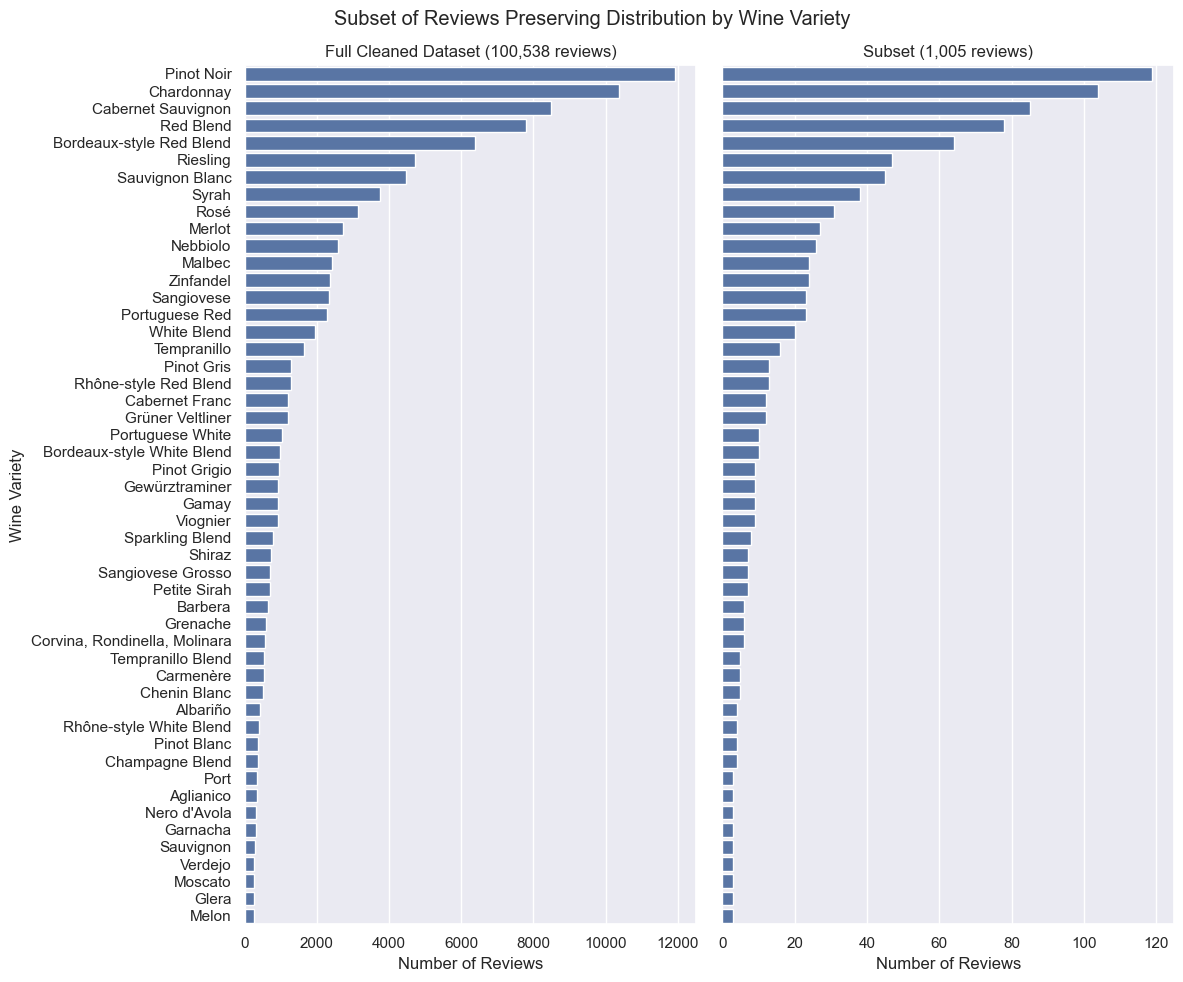

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 10), sharey=True)
sns.barplot(wine_df.variety.value_counts().sort_values(ascending=False).reset_index(), y='variety', x='count', orient='h', ax=ax[0]);
sns.barplot(subset.variety.value_counts().sort_values(ascending=False).reset_index(), y='variety', x='count', orient='h', ax=ax[1]);
plt.suptitle('Subset of Reviews Preserving Distribution by Wine Variety')
ax[0].set_xlabel('Number of Reviews')
ax[1].set_xlabel('Number of Reviews')
ax[0].set_title('Full Cleaned Dataset (100,538 reviews)')
ax[1].set_title('Subset (1,005 reviews)')
ax[0].set_ylabel('Wine Variety')
plt.tight_layout()
plt.show()

### Data Preparation

**Load NLP Library**

In [6]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /Users/patrick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/patrick/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/patrick/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/patrick/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

**Preprocessing**

In [7]:
corpus = subset.description.astype(str)
corpus

501    There's a toughness to this wine that makes it...
381    Lots of acidity gives this Merlot a bite. It's...
283    Marginally better than the regular Chardonnay,...
29     The wine is equally sharp, with a spicy blend ...
125    Pretty thin in substance, but clean, dry and p...
                             ...                        
992    “Wow” is the first word that comes to mind whe...
296    Santa Barbara-raised Steve Gerbac makes a winn...
795    This wine is pale pink in color, with aromas s...
642    Made of 80% Sangiovese, 10% Colorino and 10% C...
577    Bottled to celebrate the brand's 15th annivers...
Name: description, Length: 1005, dtype: object

#### Tokenization & Normalization Helper

This is the expensive preprocessing we want to perform on the descriptions.

**Named Entity Recognition**

In [8]:
import string
from nltk import word_tokenize
from nltk.stem import PorterStemmer,  WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
from unidecode import unidecode

# https://medium.com/quantrium-tech/top-3-packages-for-named-entity-recognition-e9e14f6f0a2a

# TODO look at SpaCY for NER: https://spacy.io/
swords = stopwords.words('english')

def clean_review(description, lemmatize=True) -> str:
  # tokenize: expand contractions, remove accents and convert text to tokens
  tokens = word_tokenize(contractions.fix(unidecode(description, errors='preserve')))
  
  # part-of-speech tagging
  token_pos = nltk.pos_tag(tokens)

  # named entity recognition
  named_entities = []
  for t in nltk.ne_chunk(token_pos):
    if hasattr(t,'label'):
      e_name = ' '.join(c[0] for c in t.leaves())
      e_type = t.label()
      named_entities.append((e_name, e_type))
  
  # remove named entities
  for ne in named_entities:
    if ne[1]=='PERSON' or ne[1] == 'PROPN':
      for name in nltk.word_tokenize(ne[0]):
        if len(tokens) > 0 and name in tokens:
          tokens.remove(name)
        # else:
        #   print('INFO: ', name, 'in', ne[0], 'is not in tokens for', description)
          # do nothing
    

  # tokens to keep
  keep = lambda word: (word not in string.punctuation) and (word not in swords)
  # normalize tokens
  normalize = WordNetLemmatizer().lemmatize if lemmatize else PorterStemmer().stem

  # run the preprocess pipeline and return the tokenized and normalized description
  return ' '.join(map(normalize, filter(keep, map(lambda word: word.lower(), tokens))))


**Spot check the preprocess method**

In [9]:
description = corpus.sample(1, random_state=42).values[0]
display(Markdown(description))
res = clean_review(description)
display(Markdown(res))

A trail of smoke wafts from start to finish on this dry, medium-bodied Chardonnay from Fox Run. Refreshing and lean on the palate with an abundance of fresh apple flavors, it's bright and clean with a lemony acidity that shines.

trail smoke waft start finish dry medium-bodied chardonnay refreshing lean palate abundance fresh apple flavor bright clean lemony acidity shine

### Baseline Measurement with No Parallelization on Subset of Wine Review Descriptions

**Collect Performance Data**

In [10]:
from time import perf_counter

t = []

def timeit(label, func):
  start = perf_counter()
  r = func()
  t.append((label, perf_counter()-start))
  return r

In [11]:
import time

# preprocess the corpus - single threaded
timeit('pandas.apply', lambda: corpus.apply(clean_review))

501    toughness wine make little hard appreciate tan...
381    lot acidity give merlot bite bone dry pretty t...
283    marginally better regular chardonnay offer thi...
29     wine equally sharp spicy blend bordeaux grape ...
125    pretty thin substance clean dry proper enough ...
                             ...                        
992    `` wow '' first word come mind tasting superco...
296    santa barbara-raised make winning white wine a...
795    wine pale pink color aroma suggesting herb che...
642    made 80 sangiovese 10 10 delicate aroma sugges...
577    bottled celebrate brand 's 15th anniversary ``...
Name: description, Length: 1005, dtype: object

In [12]:
from datetime import timedelta

elapsed = timedelta(seconds=wine_df.shape[0]/corpus.shape[0]*t[0][1])
display(Markdown(f'**Take Away**\n\nIt would take over ${elapsed.seconds/3600:.0f}$ hours to preprocess all the wine review descriptions.'))

**Take Away**

It would take over $10$ hours to preprocess all the wine review descriptions.

### Comparison of Parallel Processing on Subset of Wine Review Descriptions

**Swifter**

In [13]:
import swifter

# preprocess the corpus on multiple cores
timeit('swifter', lambda: corpus.swifter.apply(clean_review))

Pandas Apply:   0%|          | 0/1005 [00:00<?, ?it/s]

501    toughness wine make little hard appreciate tan...
381    lot acidity give merlot bite bone dry pretty t...
283    marginally better regular chardonnay offer thi...
29     wine equally sharp spicy blend bordeaux grape ...
125    pretty thin substance clean dry proper enough ...
                             ...                        
992    `` wow '' first word come mind tasting superco...
296    santa barbara-raised make winning white wine a...
795    wine pale pink color aroma suggesting herb che...
642    made 80 sangiovese 10 10 delicate aroma sugges...
577    bottled celebrate brand 's 15th anniversary ``...
Name: description, Length: 1005, dtype: object

**Joblib**

In [14]:
from joblib import Parallel, delayed

# preprocess the corpus on multiple cores
timeit(
  'joblib', 
  lambda: pd.Series(
    Parallel(n_jobs=4, verbose=0, batch_size=32)(delayed(clean_review)(description) for description in corpus.to_list()), index=corpus.index
  )
)

501    toughness wine make little hard appreciate tan...
381    lot acidity give merlot bite bone dry pretty t...
283    marginally better regular chardonnay offer thi...
29     wine equally sharp spicy blend bordeaux grape ...
125    pretty thin substance clean dry proper enough ...
                             ...                        
992    `` wow '' first word come mind tasting superco...
296    santa barbara-raised make winning white wine a...
795    wine pale pink color aroma suggesting herb che...
642    made 80 sangiovese 10 10 delicate aroma sugges...
577    bottled celebrate brand 's 15th anniversary ``...
Length: 1005, dtype: object

**mapply**

In [15]:
import mapply

# configure the multiprocessing environment
mapply.init(
    n_workers=4,
    chunk_size=16,
    max_chunks_per_worker=0,
    progressbar=True
)

# preprocess the corpus on multiple cores
timeit('mapply', lambda: corpus.mapply(clean_review))

  0%|          | 0/62 [00:00<?, ?it/s]

501    toughness wine make little hard appreciate tan...
381    lot acidity give merlot bite bone dry pretty t...
283    marginally better regular chardonnay offer thi...
29     wine equally sharp spicy blend bordeaux grape ...
125    pretty thin substance clean dry proper enough ...
                             ...                        
992    `` wow '' first word come mind tasting superco...
296    santa barbara-raised make winning white wine a...
795    wine pale pink color aroma suggesting herb che...
642    made 80 sangiovese 10 10 delicate aroma sugges...
577    bottled celebrate brand 's 15th anniversary ``...
Name: description, Length: 1005, dtype: object

**Dask**

In [16]:
from dask.dataframe import from_pandas
from dask.distributed import Client

# configure the multiprocessing environment, 1 thread per worker since NLTK is not thread safe.
# other configurations are possible.
client = Client(threads_per_worker=1, n_workers=4)

ddf = from_pandas(corpus, sort=False, chunksize=32)
# preprocess the corpus on multiple cores
timeit('dask', lambda: ddf.apply(clean_review, meta=('description', 'object')).compute())

client.close()

#### Comparison of results

In [17]:
timing = pd.DataFrame(t, columns=['library','time (s)'])
timing['process'] = np.where(timing.library == 'pandas.apply', 'single threaded', 'parallel')
timing = timing.sort_values(['process', 'time (s)'], ascending=[False, False])
timing

,library,time (s),process
0,pandas.apply,350.267815,single threaded
1,swifter,384.298320,parallel
4,dask,124.931700,parallel
2,joblib,117.906692,parallel
3,mapply,113.809949,parallel


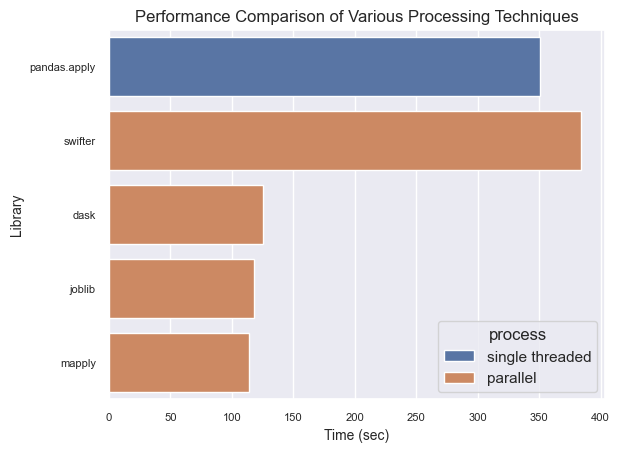

In [18]:
sns.barplot(timing, x='time (s)', y='library', hue='process')
plt.title("Performance Comparison of Various Processing Techniques", fontsize=12)
plt.xlabel("Time (sec)",fontsize=10)
plt.ylabel("Library",fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [19]:
display(Markdown(
  f'**Result**\n\n It would take the {timing.library.to_list()[-1]} library around ' + 
  f'${wine_df.shape[0]/corpus.shape[0] * timedelta(seconds=timing["time (s)"].to_list()[-1]).seconds / 3600:.0f}$ ' +
  'hours to preprocess all the wine review descriptions. Big improvement. Still long. Worth persisting the preprocessing results.'
))

**Result**

 It would take the mapply library around $3$ hours to preprocess all the wine review descriptions. Big improvement. Still long. Worth persisting the preprocessing results.

#### Conclusion on Parallel Processing Options

`Dask`, `joblib`, and `Mapply` appear to be the fastest performers, all achieving a $3x$ improvement in processing speed. `Dask` and `Mapply` are easy to use and fit into the panda syntax we are familiar with. `joblib` is equally easy to use and just requires wrapping the results into a panda series. Any of these alternatives are suitable.

Parallelizing and persisting the descriptions will have a lot of benefits. Parallelizing will allow the preprocessing to be done once in a reasonable amount of time. Persistence will allow us to train multiple models without having to rerun this expensive process.

### Parallel Processing using Joblib

Chosen for simplicity.

**Preprocess the descriptions into the `normalized_description` column**

In [20]:
# process the wine reviews in parallel
start = perf_counter()
wine_df['normalized_description'] = pd.Series(
  Parallel(n_jobs=4, verbose=0, batch_size=32)(
    delayed(clean_review)(description, swords.copy())
    for description in wine_df.description
  ),
  index=wine_df.index
)
display(Markdown(f'Preprocessing ${wine_df.shape[0]:,d}$ in **parallel** took ${(perf_counter()-start)/3600:.0f}$ hours to process.'))

Preprocessing $100,538$ in **parallel** took $3$ hours to process.

**Inspect the result**

In [21]:
wine_df.info()
wine_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100538 entries, 0 to 129970
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   country                   100538 non-null  object 
 1   description               100538 non-null  object 
 2   points                    100538 non-null  int64  
 3   price                     93522 non-null   float64
 4   taster_name               100538 non-null  object 
 5   title                     100538 non-null  object 
 6   variety                   100538 non-null  object 
 7   winery                    100538 non-null  object 
 8   year                      100538 non-null  int64  
 9   wine_style                100538 non-null  object 
 10  type                      100538 non-null  object 
 11  quality                   100538 non-null  object 
 12  classification            100538 non-null  object 
 13  location                  100538 non-null  object

,country,description,points,price,taster_name,title,variety,winery,year,wine_style,type,quality,classification,location,band,preprocessed_description,normalized_description
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013,light_white,white,medium,Old World,Etna,None,aroma include tropical fruit broom brimstone...,aroma include tropical fruit broom brimstone d...
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,medium_red,red,medium,Old World,Douro,popular,do ripe fruity wine smooth structure firm tann...,ripe fruity wine smooth still structured firm ...
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,light_white,white,medium,New World,Oregon,popular,rainstorm tart snappy flavor lime flesh rind d...,tart snappy flavor lime flesh rind dominate gr...
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,aromatic_white,white,medium,New World,Michigan,popular,pineapple rind lemon pith orange blossom start...,pineapple rind lemon pith orange blossom start...
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,light_red,red,medium,New World,Oregon,luxury,vintner like regular bottling come rough tanni...,much like regular bottling 2012 come across ra...


**View Tokens After Preprocessing**

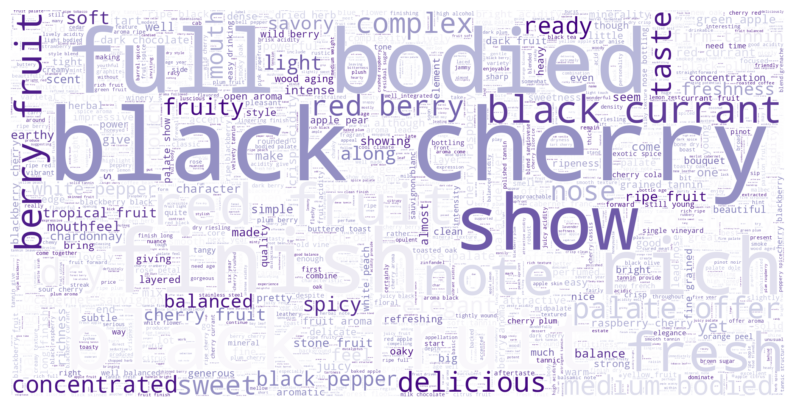

In [23]:
import wordcloud as wc

# helper Function for display frequency of words
def freq_words(words, title=None, show_v=False):
  '''
  Show frequency of words as an image
  '''

  stopwords = set(wc.STOPWORDS)
  stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

  # Generate frequency of words as an image
  freq_words_img = wc.WordCloud(stopwords=stopwords, background_color='white', colormap='Purples', width=2048,height=1024, max_words=2500).generate(words)

  # print the vector of words extracted from the description
  if show_v:
    print(freq_words_img.words_)

  # Display the image
  plt.figure(figsize=(10, 10))
  if title is not None:
    plt.title(title)
  plt.imshow(freq_words_img, interpolation="bilinear")
  plt.axis("off")
  plt.show()

# show a word cloud of the features extracted from the description
freq_words(' '.join(wine_df.normalized_description))

# Next
- [NLP Toolkit Selection](wine_reviews-nlp_selection.ipynb), explore alternatives like [spaCy](https://spacy.io/) to see if they perform better.